# Section 1: Initial Exploration and Preprocessing


<div style="text-align: justify;">
This section contains a comprehensive overview of the assigned data, starting with a detailed description and characterization based on existing documentation and literature. It includes a concise summary of the data's characteristics derived from an initial exploratory analysis, highlighting key statistics and observations. The section also describes the steps taken for data preparation and pre-processing, providing justification for each choice to ensure the data is clean, transformed, and organized for further analysis. Additionally, initial exploratory graphs are presented to visually illustrate the main characteristics of the data, helping to understand patterns, trends, and potential issues within the dataset.
 </div>

- **Set up the Environment and Upload data**;
- **DisGeNET : Gene Disease Association (GDA)**;
- **Exploratory Analysis:** Gene and Disease Frequency Analysis, Gene-Disease Scores Analysis, Target Distribution;
- **Data Preprocessing:** Transformation of the "Disease" Column (Textual Descriptions of Diseases), Transformation of the "Gene" Column (Amino Acid Sequences), Feature Integration, Handling Missing Values, Normalizing Numerical Features;
- **Splitting the Dataset into Train, Validation, and Test Sets.**

In [95]:
#packages
from tdc.multi_pred import GDA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import pdist, squareform

## Set up the Environment and Upload data

<div style="text-align: justify;">
To ensure that all the project's dependencies are installed correctly, we recommend using a Conda environment.

You can easily create the environment with the project's dependencies from the env.yml file included in this repository.
To download the dataset, we will use the GDA class from the tdcommons.multi_pred package.

In [96]:
# To use the DisGeNET dataset with TDC platform, we use the following code:
data = GDA(name='DisGeNET')
print("Data uploading completed :)")

Found local copy...
Loading...
Done!


Data uploading completed :)


## DisGeNET : Gene Disease Association (GDA) 

In [97]:
HTML('<div style="display: flex; justify-content: center;"><img src="https://www.ensembl.info/wp-content/uploads/2021/04/disgenet-logo-horizontal.png" width="400"/></div>')

The study of **gene-disease associations is a crucial step in understanding the etiology of diseases**. Identifying the link between genes and diseases makes it possible to better understand the cause of the disease and therefore to develop strategies to combat it. This process is fundamental to the advancement of medicine and the development of new therapies. [1]

    

**Therapeutics Data Commons (TDC) is a database created to promote the discovery of therapies for diseases**, especially those that are difficult to treat. It was developed by the National Institutes of Health with the aim of gathering genomic and clinical data from various sources to support biomedical research and the development of new treatments. [2]


**GDA quantify the relation among a pair of gene-disease** and is one of the core concepts of DisGeNet platform that are integrated on TDC. DisGeNET is a discovery platform containing one of the largest publicly available collections of genes and variants associated to human diseases. **DisGeNET integrates data from expert curated repositories, Genome-Wide Association Study catalogues, animal models and the scientific literature**. DisGeNET data are homogeneously annotated with controlled vocabularies and community-driven ontologies. TDC uses the curated subset from UNIPROT, CGI, ClinGen, Genomics England, CTD (human subset), PsyGeNET, and Orphanet. TDC maps disease ID to disease definition through MedGen and maps GeneID to uniprot amino acid sequence. [3]


This dataset contains **52,476 gene-disease pairs:** 7,399 unique genes and 7,095 unique diseases.                                   
As we can see by de code bellow we have an object with 52,476 rows and 5 columns: *'Gene_ID'*, *'Gene'*, *'Disease_ID'*, *'Disease'*, *'Y'*. 

- **Gene_ID** column contains all unique identifiers for genes.
- **Gene** column contains the sequences of amino acids corresponding to each gene_ID through Uniprot platform.
- **Disease_ID** column contains all unique identifiers for diseases.
- **Disease** column contains the disease definition corresponding to each disease_ID through MedGen-NCBI platform.
- The **Y** column is the target characteristic and represents the association score for a gene-disease pair. This column has values between 0 and 1. A score closer to zero indicates a weaker association and a score closer to 1 indicates a strong association. 

As our target feature is a numeric one, our work will be a regression problem when the main task is: *Given the disease description and the amino acid sequence of the gene, predict their association*.

In [98]:
#Load data and inspecting GDA dataset
full_data = data.get_data()
full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52476 entries, 0 to 52475
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gene_ID     52476 non-null  int64  
 1   Gene        52476 non-null  object 
 2   Disease_ID  52476 non-null  object 
 3   Disease     52476 non-null  object 
 4   Y           52476 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.0+ MB


,Gene_ID,Gene,Disease_ID,Disease,Y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0007102,Malignant tumor of colon: A primary or metasta...,0.31
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0009375,Colonic Neoplasms: A benign or malignant neopl...,0.30


In [99]:
data.print_stats()

--- Dataset Statistics ---
7399 unique genes.
7095 unique diseases.
52476 gene-disease pairs.
--------------------------


## 1.1. Exploratory Analysis

The exploratory data analysis will involve a comprehensive investigation of the dataset's characteristics. This will entail summarizing numerical and categorical data, analyzing the distribution of the target variable, and identifying patterns in gene-disease associations. Key tasks include examining the frequency distribution of genes and diseases, exploring the lengths of gene sequences, and assessing pairwise relationships between genes and diseases. Visualizations such as histograms, bar plots, and heatmaps will be utilized to uncover trends and potential anomalies. Furthermore, correlation analysis will be employed to understand dependencies between features, laying the groundwork for subsequent feature engineering and model development.

### 1.1.1. Gene and Disease Frequency Analysis

Analyzing the frequency of genes and diseases present in the GDA dataset allows us to check how many times we can find each gene and each disease, drawing conclusions about which genes are associated with more than one disease and vice versa. 

In [100]:
# Remove everything after the first ':' in the 'Disease' column
full_data['Disease_Label'] = full_data['Disease'].str.split(':').str[0]

# Count the frequency of each disease
disease_counts = full_data['Disease_Label'].value_counts().head(10)

# Create a DataFrame with Disease and Frequency columns
disease_df = disease_counts.reset_index()
disease_df.columns = ['Disease', 'Frequency']

# Display the 10 most prevalent diseases
print("The 10 most prevalent diseases:")
print(disease_df)


The 10 most prevalent diseases:
                          Disease  Frequency
0    Malignant neoplasm of breast        911
1                   Schizophrenia        729
2            Colorectal Carcinoma        587
3             Prostatic Neoplasms        548
4  Malignant neoplasm of prostate        548
5                Breast Carcinoma        467
6               Mammary Neoplasms        456
7        Mammary Neoplasms, Human        454
8        Mammary Carcinoma, Human        454
9                 Liver carcinoma        439


In [101]:
# Frequency of the top 10 most common genes
gene_counts = full_data['Gene_ID'].value_counts().head(10)

# Create a dataframe with columns Gene_ID and Frequency
gene_counts_df = gene_counts.reset_index()
gene_counts_df.columns = ['Gene_ID', 'Frequency']

# Display the new dataframe
print("\nTop 10 most prevalent genes:")
print(gene_counts_df)


Top 10 most prevalent genes:
   Gene_ID  Frequency
0     7124        237
1     6648        200
2     7157        184
3     5743        183
4     3569        172
5     5728        157
6     5443        153
7     3553        142
8     4524        138
9     3845        138


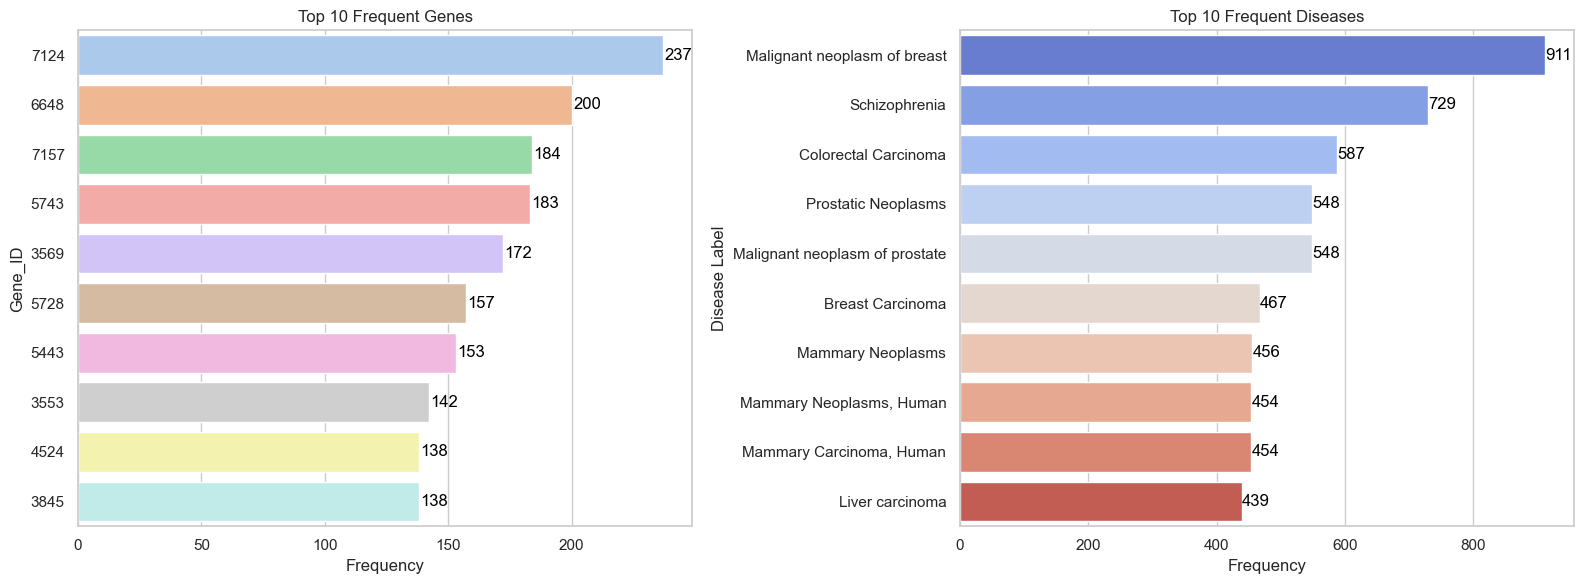

In [102]:
# Create a subplot with 2 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the top 10 most frequent genes
sns.barplot(x=gene_counts.values, y=gene_counts.index.astype(str), ax=axes[0], palette="pastel")
axes[0].set_title("Top 10 Frequent Genes")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Gene_ID")

# Add labels to the bars of the gene plot
for i, value in enumerate(gene_counts.values):
    axes[0].text(value + 0.5, i, str(value), color='black', va='center')

# Plot for the top 10 most frequent diseases
sns.barplot(x=disease_counts.values, y=disease_counts.index, ax=axes[1], palette="coolwarm")
axes[1].set_title("Top 10 Frequent Diseases")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Disease Label")

# Add labels to the bars of the disease plot
for i, value in enumerate(disease_counts.values):
    axes[1].text(value + 0.5, i, str(value), color='black', va='center')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [103]:
# Count the frequency of each Gene_ID in the dataset
gene_frequencies = full_data['Disease_Label'].value_counts()

# Sum the frequencies of the genes
total_gene_frequency = gene_frequencies.sum()

# Display the total of gene frequencies
print(total_gene_frequency)

52476


As we expected, the sum of the gene frequencies is equal to the number of gene-disease associations: 52476.

By analyzing the bar charts we can see that there is a clear predominance of some specific genes with a high frequency of association with diseases. For example, the gene with the highest frequency (Gene_ID 7124) appears in 237 gene-disease pairs, while the restnates in the top 10 vary between 200 and 138 associations.
These results indicate that there are genes with greater involvement in multiple pathological conditions. The high frequency of these genes may be a result of their participation in fundamental biological processes, such as cell cycle regulation, apoptosis or immune response.

In this exploratory phase, in order to give biological significance to the analysis, we decided to enrich the dataset with descriptions associated with the unique gene identifiers. Using a Python script, we automated the requests to the NCBI API, where, for each Gene_ID present in the dataset, we extracted the “Description” field from the responses in XML format. The “Description” field gives us the official name associated with the gene at NCBI. The results were saved in a CSV file containing the Gene_ID and its description.

The code used is shown below, however, for reasons of computational efficiency, we have not re-run the code and have accessed the generated csv file directly.

In [104]:
#gene_ncbi_ids = full_data['Gene_ID'].tolist()

# Remove duplicates using set
#unique_gene_ids = list(set(gene_ncbi_ids))

In [105]:
#import requests
#import csv
#from xml.etree import ElementTree

# List of gene IDs 
#gene_ids = unique_gene_ids

# Base URL for querying gene information
#url_base = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={}&retmode=xml'

# Open the CSV file for writing
#with open('genes_descriptions.csv', mode='w', newline='', encoding='utf-8') as file:
#    writer = csv.writer(file)
#    
    # Write the CSV header
#    writer.writerow(['GeneID', 'Description'])
    
    # Iterate over each gene_id
#    for gene_id in gene_ids:
        # Construct the URL for each gene ID
#        url = url_base.format(gene_id)
        
        # Make the request
#        response = requests.get(url)
        
        # If the request was successful
#       if response.status_code == 200:
#            tree = ElementTree.fromstring(response.content)
            
            # Try to access the Description tag directly
#            description = "Description not found"
#           for elem in tree.iter():
#                if elem.tag == "Description" and elem.text:
#                    description = elem.text.strip()
#                    break
            
            # Write the data to the CSV
#            writer.writerow([gene_id, description])
#        else:
            # In case data cannot be accessed
#            writer.writerow([gene_id, "Error accessing data"])

In [106]:
#Reading csv with the genes descriptions
df_with_genes_descriptions = pd.read_csv('genes_descriptions.csv')
print(df_with_genes_descriptions.head())

   GeneID                       Description
0       1            alpha-1-B glycoprotein
1       2             alpha-2-macroglobulin
2       9             N-acetyltransferase 1
3      12          serpin family A member 3
4      15  aralkylamine N-acetyltransferase



Thus, looking in particular at the gene with the highest frequency, with ID 7124, we found that it corresponds to Tumor Necrosis Factor (TNF). A brief search on the NCBI website revealed that this gene encodes a multifunctional proinflammatory cytokine that belongs to the TNF superfamily. This cytokine is mainly secreted by macrophages. This cytokine is involved in the regulation of a wide spectrum of biological processes including cell proliferation, differentiation, apoptosis, lipid metabolism, and coagulation. This cytokine has been implicated in a variety of diseases, including autoimmune diseases, insulin resistance, psoriasis, rheumatoid arthritis ankylosing spondylitis, tuberculosis, autosomal dominant polycystic kidney disease, and cancer. This way we can understand why it has such a high frequency in our dataset. [4]

In [107]:
# Filtering the dataset to Gene_ID 7124
gene_7124_data = df_with_genes_descriptions[df_with_genes_descriptions['GeneID'] == 7124]
print(gene_7124_data)

      GeneID            Description
3272    7124  tumor necrosis factor



To reinforce this finding, we went to the diseases column and extracted the diseases that correspond to the gene with the ID 7124. By accessing the first 10 diseases, we were able to see the diversity of conditions associated with this gene, reinforcing the multifaceted impact of TNF on conditions ranging from inflammation and autoimmune diseases to cancer and neurodegenerative diseases. It is interesting to see how it acts in such diverse systems, highlighting its potential as a therapeutic target.

In [108]:
# Filter the dataset to find associations for the TNF gene (Gene_ID: 7124)
tnf_associations = full_data[full_data['Gene_ID'] == 7124]

# Select up to 10 diseases associated with TNF and reset the index
tnf_diseases = tnf_associations[['Disease_Label']].head(10).reset_index(drop=True)

# Display the diseases
print("Diseases associated with the TNF gene:")
print(tnf_diseases)


Diseases associated with the TNF gene:
           Disease_Label
0         Adenocarcinoma
1            Albuminuria
2    Alzheimer's Disease
3                 Anemia
4     Refractory anemias
5    Anemia, Sickle Cell
6               Anorexia
7            Anthracosis
8      Anxiety Disorders
9  Arthritis, Infectious



On the other hand, the chart of the 10 most prevalent diseases shows a clear pattern of highly frequent diseases in the dataset, led by conditions such as malignant neoplasm of the breast with 911 associations and schizophrenia with 729 associations. The list is dominated by neoplasms such as breast, prostate and liver cancer, as well as the condition schizophrenia. This is in line with the existing literature, which, as we know, points to the genetic factor as one of the main contributors to these pathologies.

In [109]:
# Remove everything after the first ':' in the 'Disease' column
full_data['Disease_Label'] = full_data['Disease'].str.split(':').str[0]

# Count the frequency of each disease
disease_counts = full_data['Disease_Label'].value_counts().tail(10)  # Usando tail(10) para os menos frequentes

# Create a DataFrame with Disease and Frequency columns
disease_df = disease_counts.reset_index()
disease_df.columns = ['Disease', 'Frequency']

# Display the 10 least prevalent diseases
print("The 10 least prevalent diseases:")
print(disease_df)

The 10 least prevalent diseases:
                                         Disease  Frequency
0       Malignant hyperpyrexia due to anesthesia          1
1  EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, 69          1
2                         Congenital contracture          1
3       SINOATRIAL NODE DYSFUNCTION AND DEAFNESS          1
4                   Supraventricular tachycardia          1
5                             HEIMLER SYNDROME 1          1
6                             Brugada Syndrome 3          1
7  PEROXISOME BIOGENESIS DISORDER 4A (ZELLWEGER)          1
8              PEROXISOME BIOGENESIS DISORDER 4B          1
9             Baraitser Brett Piesowicz syndrome          1


In [110]:
# Count the frequency of each Gene_ID
gene_counts = full_data['Gene_ID'].value_counts().tail(10)  # Use tail(10) for the least frequent genes

# Create a dataframe with columns Gene_ID and Frequency
gene_counts_df = gene_counts.reset_index()
gene_counts_df.columns = ['Gene_ID', 'Frequency']

# Display the new dataframe
print("\nTop 10 least prevalent genes:")
print(gene_counts_df)



Top 10 least prevalent genes:
   Gene_ID  Frequency
0    57521          1
1     8638          1
2     8650          1
3     8654          1
4    57509          1
5    57498          1
6     8662          1
7     8666          1
8    57480          1
9     8974          1


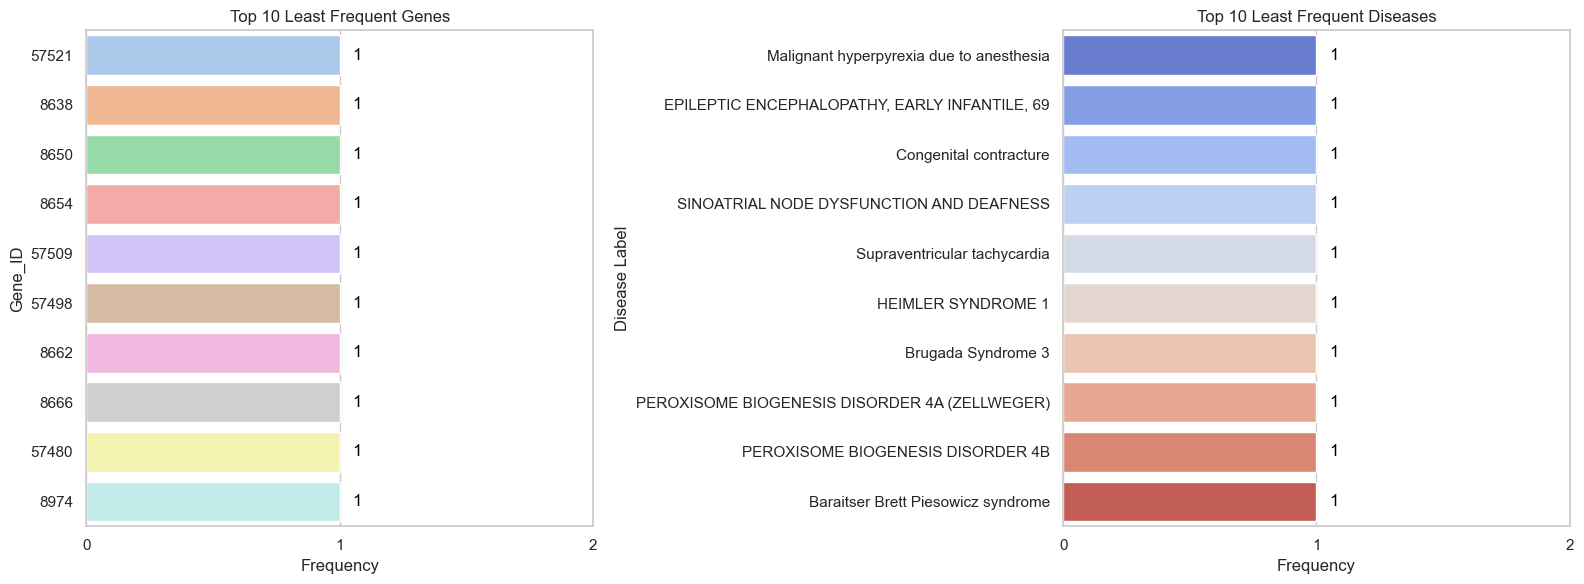

In [111]:
# Create a subplot with 2 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the 10 least frequent genes
sns.barplot(x=gene_counts.tail(10).values, y=gene_counts.tail(10).index.astype(str), ax=axes[0], palette="pastel")
axes[0].set_title("Top 10 Least Frequent Genes")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Gene_ID")

# Set the x-axis limit to 3 and ticks from 0 to 3 with interval of 1
axes[0].set_xlim(0, 2)
axes[0].set_xticks([0, 1, 2])

# Add labels to the bars of the gene plot
for i, value in enumerate(gene_counts.tail(10).values):
    axes[0].text(value + 0.05, i, str(value), color='black', va='center')

# Plot for the 10 least frequent diseases
sns.barplot(x=disease_counts.tail(10).values, y=disease_counts.tail(10).index, ax=axes[1], palette="coolwarm")
axes[1].set_title("Top 10 Least Frequent Diseases")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Disease Label")

# Set the x-axis limit for the disease plot to 3 and ticks from 0 to 3 with interval of 1
axes[1].set_xlim(0, 2)
axes[1].set_xticks([0, 1, 2])

# Add labels to the bars of the disease plot
for i, value in enumerate(disease_counts.tail(10).values):
    axes[1].text(value + 0.05, i, str(value), color='black', va='center')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [112]:
# Filtering the dataset to Gene_ID 7124
gene_57521_data = df_with_genes_descriptions[df_with_genes_descriptions['GeneID'] == 57521]
print(gene_57521_data)

      GeneID                                      Description
6613   57521  regulatory associated protein of MTOR complex 1


In [113]:
# Filter the dataset to find associations for the regulatory associated protein of MTOR complex 1 gene (Gene_ID: 57521)
_57521_associations = full_data[full_data['Gene_ID'] == 57521]

# Select up to 10 diseases associated with the gene and reset the index
_57521_associations = _57521_associations[['Disease_Label']].head(10).reset_index(drop=True)

# Display the diseases
print("Diseases associated with 57521 Gene_ID:")
print(_57521_associations)

Diseases associated with 57521 Gene_ID:
         Disease_Label
0  Nicotine Dependence



When analyzing the less frequent genes, specifically for the gene with ID 57521, we find that it refers to the RAPTOR gene. The gene regulatory associated protein of MTOR complex 1 (RAPTOR) is associated with the Akt/mTOR pathway, which is essential for cell growth and survival. According to a study, RAPTOR plays an important role in tobacco-induced lung cancer. Tobacco use, responsible for 85-90% of lung cancer cases, activates this pathway, promoting cell proliferation and tumor formation. Nicotine, the main component of tobacco, may influence this pathway, affecting not only dependence but also predisposition to cancer. Inhibitors of the Akt/mTOR pathway have shown therapeutic potential in lung cancer models, making them a promising approach for the treatment and prevention of the disease in smokers. [5]

In [114]:
#Filter genes that appear only once
gene_frequencies = full_data['Gene_ID'].value_counts()
genes_once = gene_frequencies[gene_frequencies == 1]

print("Genes that appear only once:")
print(genes_once)

Genes that appear only once:
4294     1
5724     1
5269     1
84669    1
5122     1
        ..
57498    1
8662     1
8666     1
57480    1
8974     1
Name: Gene_ID, Length: 1770, dtype: int64



We can see that there are 1770 gene_IDs that appear only once.

In [115]:
disease_frequencies = full_data['Disease_Label'].value_counts()
disease_once = disease_frequencies[disease_frequencies == 1]

print("Diseases that appear only once:")
print(disease_once)

Diseases that appear only once:
Mental Retardation, X-Linked, Syndromic, Turner Type    1
Drug Resistant Epilepsy                                 1
Ureteral Neoplasms                                      1
Thiamine responsive megaloblastic anemia syndrome       1
Thiamine-responsive megaloblastic anemia                1
                                                       ..
HEIMLER SYNDROME 1                                      1
Brugada Syndrome 3                                      1
PEROXISOME BIOGENESIS DISORDER 4A (ZELLWEGER)           1
PEROXISOME BIOGENESIS DISORDER 4B                       1
Baraitser Brett Piesowicz syndrome                      1
Name: Disease_Label, Length: 3998, dtype: int64



We can see that there are 3998 diseases that appear only once.

In [116]:
# Filter the gene-disease pairs that correspond to genes and diseases that appear once
matching_pairs = full_data[
    (full_data['Gene_ID'].isin(genes_once.index)) & 
    (full_data['Disease_Label'].isin(disease_once.index))
]

# Display the gene-disease pairs with their respective association scores
print("Gene-disease pairs that appear only once with their association scores:")
print(matching_pairs[['Gene_ID', 'Disease_Label', 'Y']])

# Get the maximum score for these pairs
max_score = matching_pairs['Y'].max()

# Get the minimum score for these pairs
min_score = matching_pairs['Y'].min()

# Display the maximum and minimum scores
print(f"\nMaximum score associated with unique pairs: {max_score}")
print(f"Minimum score associated with unique pairs: {min_score}")

Gene-disease pairs that appear only once with their association scores:
       Gene_ID                                      Disease_Label     Y
39          16       Charcot-Marie-Tooth Disease, Axonal, Type 2n  0.71
156         33       Long chain acyl-CoA dehydrogenase deficiency  0.50
543        112           LETHAL CONGENITAL CONTRACTURE SYNDROME 8  0.71
1341       211                  Disorders of Porphyrin Metabolism  0.52
1682       265  Amelogenesis Imperfecta, Hypomaturation Type, ...  0.60
...        ...                                                ...   ...
52055   341208  Pili torti developmental delay neurological ab...  0.30
52086   343637          NAIL DISORDER, NONSYNDROMIC CONGENITAL, 4  0.70
52177   374354  FIBROSIS, NEURODEGENERATION, AND CEREBRAL ANGI...  0.43
52250   387733                    Osteogenesis imperfecta, type 5  0.80
52295   390594                                Nemaline myopathy 6  0.70

[245 rows x 3 columns]

Maximum score associated with unique pa

### 1.1.2. Gene-Disease Scores Analysis

The analysis of gene-disease pairs with the highest association scores is crucial because it offers fundamental insights for understanding the causes of diseases, boosting new treatments and improving human health in a more personalized and precise way.

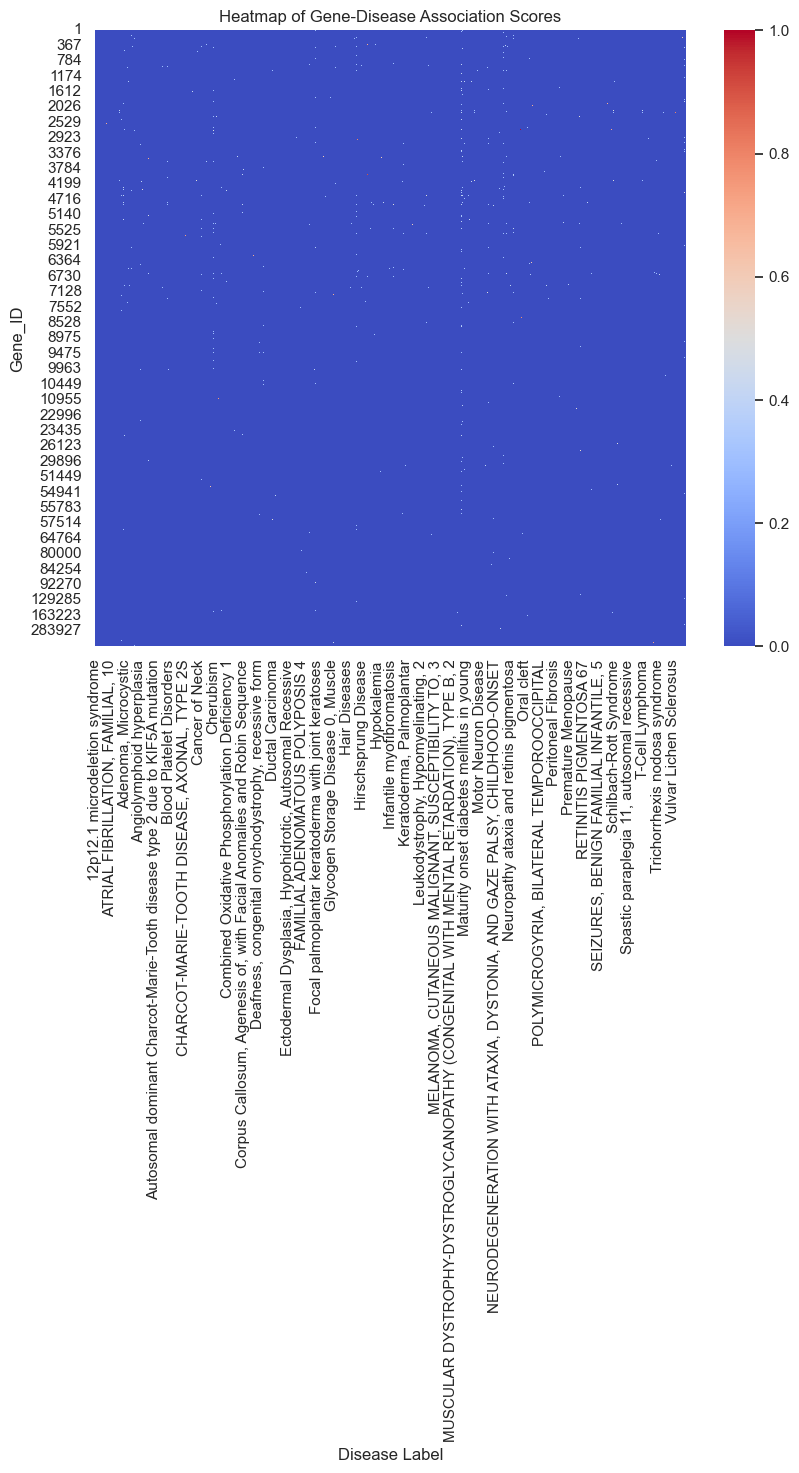

In [117]:
# Aggregation by 'Y' values
pair_scores = full_data.groupby(['Gene_ID', 'Disease_Label'])['Y'].mean().reset_index(name='Mean_Score')
pair_scores = pair_scores.sort_values(by='Mean_Score', ascending=False)

# Visualizing the pair score
plt.figure(figsize=(10, 8))
heatmap_data = pair_scores.pivot('Gene_ID', 'Disease_Label', 'Mean_Score').fillna(0)

sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True, square=True)
plt.title("Heatmap of Gene-Disease Association Scores")
plt.xlabel("Disease Label")
plt.ylabel("Gene_ID")
plt.show()


We can see from the heatmap that most gene-disease pairs have a score below 0.2 and that there are some points that indicate a strong association.

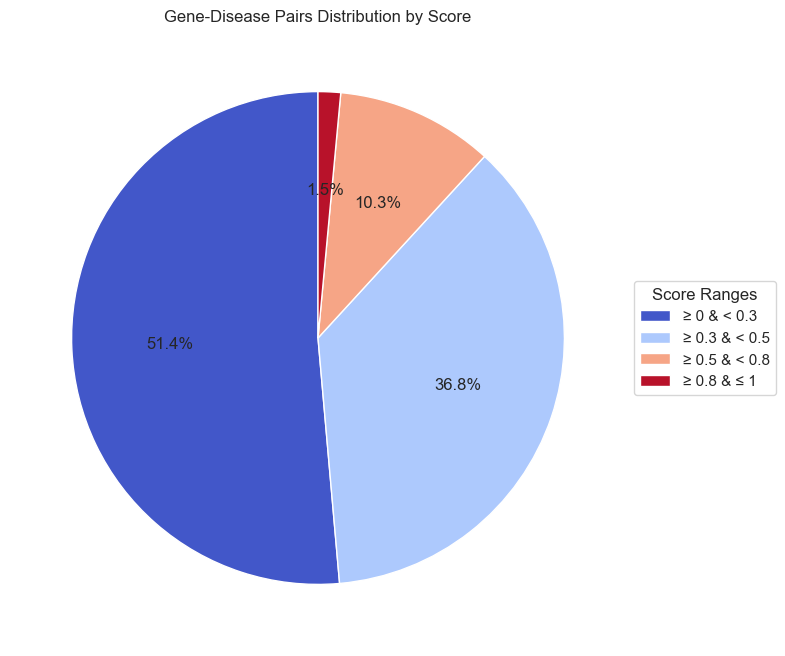

In [118]:
# Define the score intervals
bins = [0, 0.3, 0.5, 0.8, 1]
labels = ['0 - 0.3', '0.3 - 0.5', '0.5 - 0.8', '0.8 - 1']

# Categorize the gene-disease pairs into the defined intervals
full_data['Score_Category'] = pd.cut(full_data['Y'], bins=bins, labels=labels, include_lowest=True)

# Count the number of pairs in each category
score_distribution = full_data['Score_Category'].value_counts()

# Define specific colors for each interval
colors = ['#4257C9', '#ADC9FD', '#F6A586', '#B8122A']

# Define detailed descriptions for each interval with symbols
detailed_labels = [
    "≥ 0 & < 0.3", 
    "≥ 0.3 & < 0.5", 
    "≥ 0.5 & < 0.8", 
    "≥ 0.8 & ≤ 1"
]

# Plot the pie chart with the specific colors
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(score_distribution, autopct='%1.1f%%', startangle=90, colors=colors)

# Add title
plt.title("Gene-Disease Pairs Distribution by Score")

# Add the legend with the symbols
plt.legend(detailed_labels, title="Score Ranges", loc='center left', bbox_to_anchor=(1, 0.5))

# Display the chart
plt.show()


The circular graph shows that 88.2% of the gene-disease pairs have a score below 0.5 and that only 1.5% have a strong association with a score between 0.8 and 1.

For a more detailed analysis, we looked for gene-disease pairs that had an association score of 1, representing a strong influence of the gene on the disease.

In [119]:
# Count the number of gene-disease pairs with an association score of 1
pairs_with_score_1 = full_data[full_data['Y'] == 1]

# Display the number of pairs with an association score of 1
print(f"Number of Gene-Disease pairs with association score of 1: {len(pairs_with_score_1)}")

# Display the gene-disease pairs with score=1
print("\nGene-Disease pairs with score = 1:")
print(pairs_with_score_1[['Gene_ID', 'Disease_Label', 'Y']].head(10))

Number of Gene-Disease pairs with association score of 1: 335

Gene-Disease pairs with score = 1:
      Gene_ID                                      Disease_Label    Y
73         19                                    Tangier Disease  1.0
104        24                                Stargardt's disease  1.0
106        24                     STARGARDT DISEASE 1 (disorder)  1.0
163        34  Medium-chain acyl-coenzyme A dehydrogenase def...  1.0
169        35            Deficiency of butyryl-CoA dehydrogenase  1.0
178        37  Very long chain acyl-CoA dehydrogenase deficiency  1.0
400        90              Fibrodysplasia Ossificans Progressiva  1.0
887       175                             Aspartylglucosaminuria  1.0
915       178                  Glycogen Storage Disease Type III  1.0
1076      190                        X-linked Adrenal Hypoplasia  1.0


In [120]:
# Filtering the dataset to Gene_ID 19
gene_7124_data = df_with_genes_descriptions[df_with_genes_descriptions['GeneID'] == 19]
print(gene_7124_data)

   GeneID                                Description
7      19  ATP binding cassette subfamily A member 1




In the first example, we have the gene with ID 19 corresponding to Tangier disease. Accessing the supporting dataset “df_with_genes_descriptions” we see that ID 19 encodes the ATP binding cassette subfamily A member 1.

The membrane-associated protein encoded by this gene is a member of the ATP-binding cassette (ABC) transporter superfamily. ABC proteins transport various molecules across extra- and intracellular membranes. This protein is a member of the ABC1 subfamily. Members of the ABC1 subfamily are the only major ABC subfamily found exclusively in multicellular eukaryotes. With cholesterol as its substrate, this protein functions as a cholesterol efflux pump in the cellular lipid removal pathway. Mutations in both alleles of this gene cause Tangier disease and familial high-density lipoprotein (HDL) deficiency. Tangier disease is a rare genetic disorder characterized by the absence or extremely low levels of high-density lipoprotein (HDL), which is what is commonly referred to as “good cholesterol”. [6]

The strong association between gene-disease pairs highlights genes that are fundamental to the biological processes of the disease, indicating their crucial role in pathogenesis and potential as therapeutic targets. Highly associated pairs can guide drug development, help identify biomarkers for early diagnosis and contribute to personalizing treatments. 

### 1.1.3. Target Distribution

Before applying any machine learning model or analysis, it is essential to understand the distribution of the target (in this case, the variable 
Y, which represents the strength of the association between gene and disease). 
The distribution of the target gives us an initial view of how the data is organized, whether there is imbalance or whether the values are concentrated in a specific range. By examining the target distribution, we can identify patterns, asymmetry, outliers and whether the data is normally distributed or not. This step is crucial to understanding the nature of the data, which can influence later decisions, such as the treatment of outliers, the choice of machine learning model and the need for pre-processing.

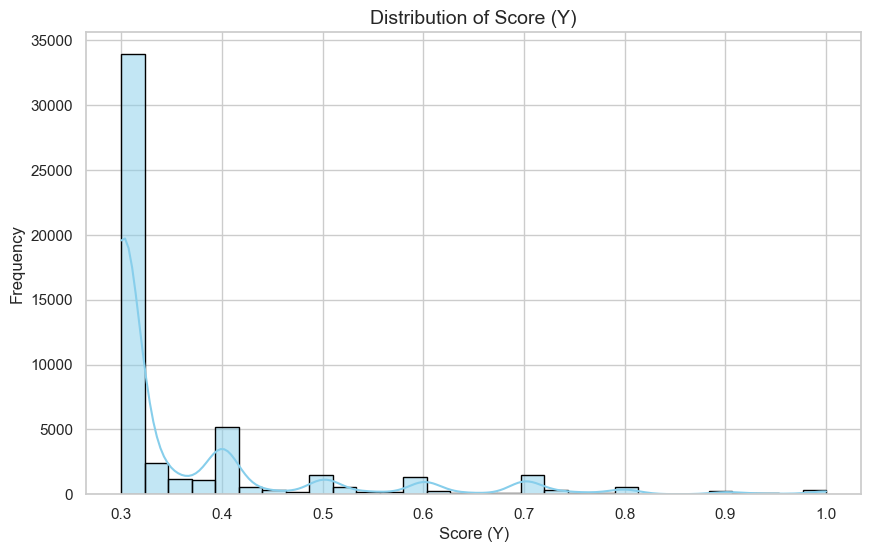

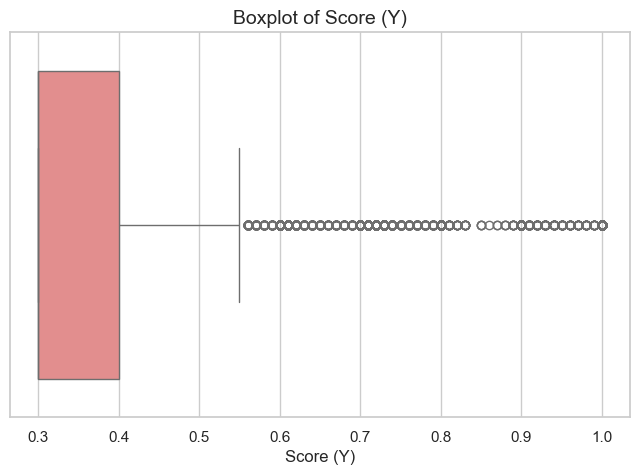

In [121]:
# General style settings
sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(full_data['Y'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Score (Y)", fontsize=14)
plt.xlabel("Score (Y)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=full_data['Y'], color='lightcoral')
plt.title("Boxplot of Score (Y)", fontsize=14)
plt.xlabel("Score (Y)", fontsize=12)
plt.show()

In [122]:
# Calculate Q1 (first quartile), Q3 (third quartile), and IQR
Q1 = full_data['Y'].quantile(0.25)
Q3 = full_data['Y'].quantile(0.75)
IQR = Q3 - Q1

# Limits for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = full_data[(full_data['Y'] < lower_bound) | (full_data['Y'] > upper_bound)]

# Count the number of outliers
num_outliers = len(outliers)

print(f"Number of outliers: {num_outliers}")

Number of outliers: 5475



Analysis of the histogram allows us to see that our target does not follow a normal distribution, with a clear concentration of pairs in scores between 0.3 and 0.4.

Based on the analysis of outliers using the interquartile range (IQR), a total of 5475 outliers were identified in the data set, which indicates that there is a significant amount of extreme values. This high number of outliers suggests that, although most of the associations are weaker or moderate, there is a considerable amount of data with very strong associations between genes and diseases. Since these outliers represent important and relevant biological associations, we decided to keep them in our analysis.

However, in order to improve the performance of the models, we will transform the Y column on the next task.

## 1.2. Data Preprocessing

Pre-processing is a crucial step to ensure the dataset is ready for analysis and modeling. 
The original “full_data” dataset, loaded from the “tdcommons.multi_pred” package, does not contain any features relevant to the learning tasks that follow. As we've seen before, the available columns - Gene_ID, Gene, Disease_ID, Disease- are made up of identifiers and textual descriptions. The columns containing IDs are just numbers that carry no meaningful information and therefore cannot be used directly to learn patterns. The columns containing textual descriptions, although they contain useful information, are unstructured data that don´t capture semantic and contextual relationships. Gene-disease association analysis requires the transformation of textual and sequential data into numerical representations that can be used in supervised learning tasks. 

In a first attempt to obtain relevant features, we analyzed the DISGENET database directly. The database allows  the creation of an account for academic purposes, where access is given to an API that facilitates the consultation of data related to genes and their associations with diseases. This API provides an efficient means of exploring and integrating biological and clinical data, giving access to parameters such as “geneProteinClassNames”, “diseaseName”, “Disease Specificity Index”, among others. However, the academic account comes with limitations, such as restrictions on the number of requests that can be made per minute/day and the volume of data accessed. Since there is also no possibility of downloading this information directly from the site, this solution was excluded.

In a second approach, we tried to create additional binary columns to represent the presence of specific organs in the description of diseases. To do this, we created a list of terms related to organs and health conditions, such as “liver”, “cancer”, “skin”, “brain”, among others, and applied a function that checked for the presence of these terms in disease descriptions. For each term found, the function assigned the value 1, otherwise 0. This process created new columns in the dataset that indicated, in binary form, the presence or absence of each of these organs or conditions in the description. However, this approach did not work properly, since there was no exact correspondence between the terms in the list and the way the diseases were described, i.e. there was a lot of loss of information, and in addition, we would have to deal with sparsity.

The third approach tested was the creation of embeddings for the "Gene" and "Disease" columns. Embeddings are numerical representations of data, such as words, phrases or even entire documents, which capture the semantics and relationships between elements in a dense and continuous way. Ulike one-hot encoding, which represents each nvalue as a sparse vector with a large number of zeros, embeddings transform information into low-dimensional vectors, where elements with similar meanings or contexts are represented by nearby vectors in the vector space. This approach reduces dimensionality while allowing the model to capture more complex relationships between data, such as synonyms or contextual associations. In the context of machine learning, embeddings are extremely useful because they allow the model to understand the semantics of the data more efficiently, facilitating generalization and the ability to learn patterns that are not explicitly present in the training data.


In this context, the "Gene" and "Disease" columns of the dataset were transformed using appropriate methods for each type of data: k-mers combined with Word2Vec for amino acid sequences, and BioBERT for textual descriptions of diseases. 

Key steps include:  

- Transformation of the "Disease" Column (Textual Descriptions of Diseases): generate embeddings through BioBERT model
- Transformation of the "Gene" Column (Amino Acid Sequences): generate embedding through k-mers + Word2Vec
- Feature integration: Combining generated features into a unified dataset.  
- Data cleaning and normalization: Handling missing values and scaling numerical features.  
- Dataset splitting: dividing the data into training, validation, and test sets.

### 1.2.1. Transformation of the "Disease" Column (Textual Descriptions of Diseases)
The "Disease" column contains textual descriptions extracted from MedGen, a database that organizes information related to human medical genetics, including attributes of conditions with a genetic contribution.
**BERT (Bidirectional Encoder Representations from Transformers)** is a pre-trained language model based on the Transformer architecture, which processes text bidirectionally, meaning it considers the full context of a word, both to the left and to the right of it. This allows BERT to better understand the meaning of words in different contexts. The model was trained on large volumes of text, such as Wikipedia and books, and is used for various Natural Language Processing tasks, such as machine translation, text classification, and named entity recognition. **BioBERT**, on the other hand, is an adaptation of BERT specifically fine-tuned for the biomedical field. It was trained on biomedical databases, such as PubMed and PMC, allowing it to understand and process the specialized terminology and concepts found in scientific and medical texts. BioBERT can generate high-quality embeddings for biomedical words and phrases, making it a valuable tool for tasks like information extraction, text classification, and question answering in the healthcare domain. [7]

In [123]:
#Packages needed to create embeddings with BioBert

#!pip install torch
#!pip install transformers
#!pip install gensim

#import torch
#from transformers import BertTokenizer, BertModel


This code demonstrates how we use BioBERT to generate embeddings for disease descriptions from a dataset.The extensive description of diseases (“Disease” column) contained many stop words and irrelevant information, such as excessive detail or general terms that are not directly useful for analysis. We therefore decided to provide the model with just the key to this dictionary, which we had already stored in a new “Disease_Label” column. This way we minimize noise and keep the information more concise and focused.

It first loads the pre-trained BioBERT model and its associated tokenizer using the transformers library. The get_biobert_embedding function tokenizes the input text (in this case, disease descriptions), processes it through BioBERT to generate embeddings, and then averages these embeddings across all tokens to produce a single vector representation for each disease. These embeddings are then added as a new column, Disease_Embedding, to the dataset. Finally, the updated dataset, now containing the generated embeddings, is saved to a CSV file for further analysis.

In [124]:
# Load BioBERT and tokenizer
#model_name = "dmis-lab/biobert-v1.1"  # pre-trained model BioBERT for biomedical tasks
#tokenizer = BertTokenizer.from_pretrained(model_name)
#model = BertModel.from_pretrained(model_name)

# Obtain embeddings by BioBERT
#def get_biobert_embedding(text, tokenizer, model):
#    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#    with torch.no_grad():
#        outputs = model(**inputs)
#    embeddings = outputs.last_hidden_state
#    embedding = embeddings.mean(dim=1).squeeze().numpy()
#    return embedding

# Generate embeddings for all disease descriptions
#full_data['Disease_Embedding'] = full_data['Disease_Label'].apply(lambda x: get_biobert_embedding(x, tokenizer, model))

# Save dataframe with disease embeddings
#full_data.to_csv('dataset_with_new_embeddings.csv', index=False)

In [125]:
#Reading csv with the disease embeddings
df_with_disease_emb = pd.read_csv('dataset_with_new_embeddings.csv')
print(df_with_disease_emb.head())

   Gene_ID                                               Gene Disease_ID  \
0        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0019209   
1        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0036341   
2        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0002395   
3        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0007102   
4        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0009375   

                    Disease     Y  \
0              Hepatomegaly  0.30   
1             Schizophrenia  0.30   
2       Alzheimer's Disease  0.50   
3  Malignant tumor of colon  0.31   
4         Colonic Neoplasms  0.30   

                                   Disease_Embedding  
0  [-2.72189286e-02 -3.29334848e-02 -1.48694739e-...  
1  [-1.29534360e-02  1.31981462e-01  3.30071747e-...  
2  [ 1.36845946e-01  1.70571357e-02  6.32009134e-...  
3  [-1.65931299e-01  8.97794664e-02 -3.93944710e-...  
4  [-1.50688425e-01 -9.06909406e-02 -4.229710

In [126]:
# Number of generated embeddings
num_embeddings = df_with_disease_emb['Disease_Embedding'].notnull().sum()
print(f"Number of generated embeddings: {num_embeddings}")

Number of generated embeddings: 52476


The code generates 52476 embeddings, each corresponding to a disease description in the dataset. Each embedding represents the semantic meaning of the disease description associated with a specific gene in the dataset.

### 1.2.2. Transformation of the "Gene" Column (Amino Acid Sequences)

The **amino acid sequences in the "Gene" column** represent the primary structure of proteins, containing fundamental information about the biological functions of genes. However, these sequences are expressed as text strings and cannot be directly processed by machine learning models. To address this, the **k-mers and Word2Vec approach** was chosen, which is widely used in bioinformatics due to its ability to capture local patterns and semantic relationships among subsequences.

The approach of generating embeddings for gene sequences using k-mers and Word2Vec transforms complex biological information into numerical representations that capture relevant patterns in gene sequences. First, the gene sequences are divided into k-mers, fixed-length subsequences, which help to identify important local patterns. Next, the Word2Vec model is used to map these k-mers to numerical vectors, taking into account the context in which they appear in the sequences. This approach allows k-mers with similar contexts to have close vector representations, reflecting significant genetic patterns. The average of the vectors of the k-mers of a sequence is then calculated, creating a fixed vector that synthesizes the information of the entire sequence. This average vector reflects the most relevant patterns and characteristics of the gene, creating features that capture the essence of the genetic sequences. [8]

In [127]:
#from itertools import islice

# Function to generate k-mers
#def generate_kmers(sequence, k=3):
#    """Split an amino acid sequence into k-mers."""
#    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Generate k-mers for each sequence
#k = 3  # Ajuste o tamanho do k-mer conforme necessário
#full_data['k_mers'] = full_data['Gene'].apply(lambda seq: generate_kmers(seq, k))

#Convert k-mers into list (expected format for Word2Vec)
#corpus = full_data['k_mers'].tolist()

In [128]:
#from gensim.models import Word2Vec

# Train the Word2Vec model
#model = Word2Vec(
#    sentences=corpus,       # List of lists of k-mers
#    vector_size=100,        # Dimension of the embeddings
#    window=5,               # Context window size
#    min_count=1,            # Minimum frequency to consider a k-mer
#    workers=4,              # Number of threads for training
#    sg=1                    # Skip-gram (1) or CBOW (0)
#)

# Save the trained model
#model.save("word2vec_model.model")

In [129]:
# Function to calculate the average vector of k-mers in a sequence

# def sequence_vector(kmers, model):
#     vectors = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
#     if vectors:
#         return np.mean(vectors, axis=0)
#     else:
#         return np.zeros(model.vector_size)

# Add average vectors to the DataFrame
# full_data['vector'] = full_data['k_mers'].apply(lambda kmers: sequence_vector(kmers, model))

# Save dataframe with sequence embeddings
#full_data.to_csv('full_data_sequence_emebdings.csv', index=False)

After generating the embeddings for the gene sequences, the updated dataframe, which now contains the sequence embeddings, is saved into a CSV file named 'full_data_sequence_embeddings.csv'. This step allows for easy storage and retrieval of the generated embeddings, enabling their subsequent use in further analysis and machine learning tasks. By using index=False, the row indices are excluded from the file, ensuring that only the relevant data, including the sequence embeddings, is saved. This approach ensures the embeddings are preserved in a structured format, ready for future processing or model training.

In [130]:
#Reading csv with the AA sequence embeddings
df_with_seq_emb = pd.read_csv('full_data_sequence_emebdings.csv')
print(df_with_seq_emb.head())

   Gene_ID                                               Gene Disease_ID  \
0        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0019209   
1        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0036341   
2        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0002395   
3        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0007102   
4        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0009375   

                                             Disease     Y  \
0   Hepatomegaly: Abnormal enlargement of the liver.  0.30   
1  Schizophrenia: Schizophrenia is highly heritab...  0.30   
2  Alzheimer's Disease: Alzheimer disease is the ...  0.50   
3  Malignant tumor of colon: A primary or metasta...  0.31   
4  Colonic Neoplasms: A benign or malignant neopl...  0.30   

                                              k_mers  \
0  ['MSM', 'SML', 'MLV', 'LVV', 'VVF', 'VFL', 'FL...   
1  ['MSM', 'SML', 'MLV', 'LVV', 'VVF', 'VFL', 'FL...   
2 

In [131]:
# Number of generated embeddings
num_embeddings = df_with_seq_emb['vector'].notnull().sum()
print(f"Number of generated embeddings: {num_embeddings}")

Number of generated embeddings: 52476


The code generates 52476 embeddings, each corresponding to a disease description in the dataset. Each embedding represents the semantic meaning of the sequence, capturing the functional and structural context of the amino acids or k-mers within the biological context.

In [132]:
full_data.columns

Index(['Gene_ID', 'Gene', 'Disease_ID', 'Disease', 'Y', 'Disease_Label',
       'Score_Category'],
      dtype='object')

In [133]:
df_with_disease_emb.columns

Index(['Gene_ID', 'Gene', 'Disease_ID', 'Disease', 'Y', 'Disease_Embedding'], dtype='object')

In [134]:
df_with_seq_emb.columns

Index(['Gene_ID', 'Gene', 'Disease_ID', 'Disease', 'Y', 'k_mers', 'vector'], dtype='object')

### 1.2.3. Feature Integration
The merge was performed to consolidate data from two separate datasets into a unified structure. This merging process ensures that all relevant information, including the embeddings generated for diseases and genes, is combined for comprehensive analysis and model training. The merge is performed using the common columns: **Gene_ID, Disease_ID, Gene, Disease, and Y**. These columns serve as unique identifiers for each gene-disease pair and ensure that the data alignment is accurate and consistent across both datasets, avoiding accidental mismatches.

In [135]:
merge_df = pd.merge(df_with_disease_emb, df_with_seq_emb, on=['Gene_ID', 'Disease_ID','Gene','Y'])

In [136]:
merge_df.columns

Index(['Gene_ID', 'Gene', 'Disease_ID', 'Disease_x', 'Y', 'Disease_Embedding',
       'Disease_y', 'k_mers', 'vector'],
      dtype='object')

In [137]:
#Verifiyng data type of the generated embeddings 
print(type(df_with_disease_emb['Disease_Embedding'].iloc[0]))
print(type(df_with_seq_emb['vector'].iloc[0]))

<class 'str'>
<class 'str'>


The conversion of the **'Disease_Embedding'** and **'vector'** columns from strings to numerical arrays is necessary to enable efficient data manipulation for mathematical analyses and use in machine learning algorithms. In their current string format, the vectors cannot be used for essential calculations or vector operations, such as distances or transformations. By transforming them into NumPy arrays, we ensure compatibility with numerical operations, improve computational efficiency, and prepare the data for future integrations with models or algorithms that require vectorized inputs.

In [138]:
# Convert the strings to numeric arrays
merge_df['Disease_Embedding'] = merge_df['Disease_Embedding'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float)
)
merge_df['vector'] = merge_df['vector'].apply(
    lambda x: np.array(x.strip('[]').split(), dtype=float))

In [139]:
print(type(merge_df['Disease_Embedding'].iloc[0]))
print(type(merge_df['vector'].iloc[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


The integration of the two datasets has resulted in a unified structure that consolidates all relevant features, including gene embeddings "vector" (from k-mers + Word2Vec) and disease embeddings "Disease_Embedding" (from BioBERT), along with their association probabilities (Y). 

In [140]:
# Columns reorder with target ('Y') on final
columns = [col for col in merge_df.columns if col != 'Y'] + ['Y']
merge_df = merge_df[columns]

In [141]:
# Remove unwanted columns
final_df = merge_df.drop(columns=['Gene', 'Disease_y', 'k_mers', 'Disease_ID'])

# Rename columns
final_df = final_df.rename(columns={'Disease_x': 'Disease', 'vector': 'Seq_Embedding'})
final_df


,Gene_ID,Disease,Disease_Embedding,Seq_Embedding,Y
0,1,Hepatomegaly,"[-0.0272189286, -0.0329334848, -0.148694739, 0...","[0.0127240745, 0.237551868, 0.204706326, 0.010...",0.30
1,1,Schizophrenia,"[-0.012953436, 0.131981462, 0.330071747, 0.117...","[0.0127240745, 0.237551868, 0.204706326, 0.010...",0.30
2,2,Alzheimer's Disease,"[0.136845946, 0.0170571357, 0.0632009134, 0.22...","[0.01349863, 0.23563088, 0.19207779, 0.0080262...",0.50
3,2,Malignant tumor of colon,"[-0.165931299, 0.0897794664, -0.39394471, -0.1...","[0.01349863, 0.23563088, 0.19207779, 0.0080262...",0.31
4,2,Colonic Neoplasms,"[-0.150688425, -0.0906909406, -0.0422971025, 0...","[0.01349863, 0.23563088, 0.19207779, 0.0080262...",0.30
...,...,...,...,...,...
52471,100507436,Oral Submucous Fibrosis,"[0.0151368026, -0.287091732, 0.0519882664, -0....","[-0.00689626, 0.25386408, 0.20322627, 0.047420...",0.31
52472,100507436,Liver carcinoma,"[-0.181769595, -0.0800423175, -0.155068621, -0...","[-0.00689626, 0.25386408, 0.20322627, 0.047420...",0.40
52473,100820829,Juvenile-Onset Still Disease,"[0.00501595158, -0.123054758, 0.0948322788, 0....","[-0.00869523, 0.21494888, 0.23836711, -0.05506...",0.30
52474,100820829,Juvenile arthritis,"[-0.0509103537, -0.137463376, 0.165860593, 0.3...","[-0.00869523, 0.21494888, 0.23836711, -0.05506...",0.30


### 1.2.4. Handling Missing Values
Despite the dataset being curated, it is crucial to explicitly check for any null values to ensure data integrity. Addressing missing data helps maintain the quality and reliability of downstream analyses.

In [142]:
# Checking for missing values
missing_values = final_df.isnull().sum()
print("Missing values detected in the dataset:")
print(missing_values)

if missing_values.sum() == 0:
    print("No missing values found.")
else:
    final_df.fillna(0, inplace=True)
    print("Missing values handled successfully by replacing them with 0.")

Missing values detected in the dataset:
Gene_ID              0
Disease              0
Disease_Embedding    0
Seq_Embedding        0
Y                    0
dtype: int64
No missing values found.


### 1.2.5. Normalizing Numerical Features

Normalizing embeddings and the Y column (target) is a fundamental step in data pre-processing, especially in machine learning models. Embeddings, such as "Seq_Embedding" and "Disease_Embedding", are vector representations of information that can vary in scale and magnitude. Without normalization, these vectors can negatively affect the performance of learning algorithms such as neural networks, which are sensitive to these differences in scale. By applying normalization, we ensure that all the features have the same range of values, facilitating the optimization process and allowing the model to learn more efficiently. Normalizing the Y column, which represents the target, is also important to ensure that the model is trained with consistent values, especially in regression tasks. This process helps to improve the model's accuracy and speeds up convergence during training.

In [143]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the Seq_Embedding column
final_df['Seq_Embedding'] = final_df['Seq_Embedding'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())

# Normalize the Disease_Embedding column
final_df['Disease_Embedding'] = final_df['Disease_Embedding'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())

# Normalize the Y (target) column if it's numeric
if final_df['Y'].dtype in ['float64', 'int64']:  # Check if Y is numeric
    final_df['Y'] = scaler.fit_transform(final_df[['Y']])

# Display a sample of the normalized data
print("Features normalized. Sample data:")
print(final_df.head())

Features normalized. Sample data:
   Gene_ID                   Disease  \
0        1              Hepatomegaly   
1        1             Schizophrenia   
2        2       Alzheimer's Disease   
3        2  Malignant tumor of colon   
4        2         Colonic Neoplasms   

                                   Disease_Embedding  \
0  [0.9017219185621199, 0.9010982331528904, 0.888...   
1  [0.9057945054973383, 0.922277640045237, 0.9448...   
2  [0.902253438627255, 0.888815818917644, 0.89399...   
3  [0.8833089380296711, 0.9118623469634305, 0.857...   
4  [0.8915357191992452, 0.8984873197230501, 0.904...   

                                       Seq_Embedding         Y  
0  [0.5822301160841719, 0.9843224393942889, 0.925...  0.000000  
1  [0.5822301160841719, 0.9843224393942889, 0.925...  0.000000  
2  [0.5882340303321985, 0.9999999999999999, 0.919...  0.285714  
3  [0.5882340303321985, 0.9999999999999999, 0.919...  0.014286  
4  [0.5882340303321985, 0.9999999999999999, 0.919...  0.000000 

In [ ]:
# Saving final_df to csv file
final_df.to_csv('final_df.csv', index=False)


### 1.3. Splitting the Dataset into Train, Validation, and Test Sets
Splitting the dataset into training, validation, and test subsets ensures a robust evaluation of the model. This division allows for efficient training, fine-tuning, and unbiased testing to assess generalization performance.

In [146]:
# Remove unnecessary columns
final_df_ML = final_df.drop(columns=['Gene_ID', 'Disease'])

# Saving final_df_ML to csv file
final_df_ML.to_csv('final_df_ML.csv', index=False)

In [147]:
# Read csv file
final_df_ML = pd.read_csv('final_df_ML.csv')

# Now let's separate the features (X) and the target (y)
# Features: 'Seq_Embedding' and 'Disease_Embedding'
# Target: 'Y'

X = final_df_ML[['Seq_Embedding', 'Disease_Embedding']]  
y = final_df_ML['Y']  

# Split into train + validation set and test set (80% train + validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train + validation set into train and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Display the shape of the datasets
print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}')

Train shape: (31485, 2), Validation shape: (10495, 2), Test shape: (10496, 2)


## References

[1] Opap, K., & Mulder, N. (2017). Recent advances in predicting gene–disease associations. F1000Research, 6, 578. https://doi.org/10.12688/f1000research.10788.1
    
[2] Therapeutics Data Commons. (2024). TDC. https://tdcommons.ai/

[3] Piñero, J., Ramírez-Anguita, J. M., Saüch-Pitarch, J., Ronzano, F., Centeno, E., Sanz, F., & Furlong, L. I. (2019). The DisGeNET knowledge platform for disease genomics: 2019 update. Nucleic Acids Research, 48(D1). https://doi.org/10.1093/nar/gkz1021

[4]]TNF tumor necrosis factor [Homo sapiens (human)] - Gene - NCBI. (n.d.). Www.ncbi.nlm.nih.gov. https://www.ncbi.nlm.nih.gov/gene/7124

[5]Memmott, R. M., & Dennis, P. A. (2009). The Role of the Akt/mTOR Pathway in Tobacco Carcinogen-Induced Lung Tumorigenesis. Clinical Cancer Research, 16(1), 4–10. https://doi.org/10.1158/1078-0432.ccr-09-0234

[6] ABCA1 ATP binding cassette subfamily A member 1 [Homo sapiens (human)] - Gene - NCBI. (2020). Nih.gov. https://www.ncbi.nlm.nih.gov/gene/19

[7] Lee, J., Yoon, W., Kim, S., Kim, D., Kim, S., So, C. H., & Kang, J. (2019). BioBERT: a pre-trained biomedical language representation model for biomedical text mining. Bioinformatics, 36(4). https://doi.org/10.1093/bioinformatics/btz682

[8]Yang, K. K., Wu, Z., Bedbrook, C. N., & Arnold, F. H. (2018). Learned protein embeddings for machine learning. Bioinformatics, 34(15), 2642–2648. https://doi.org/10.1093/bioinformatics/bty178